# ADA - Final project
This notebook aims at giving technical explanations necessary to understand how the results given in the final report were found.

First off, the following commands allow you to retrieve the data necessary to run this notebook locally from the cluster used for this class.
1. Upload the files script.sh and script.py using the following command:  
```bash 
scp -r -p /path/to/script.py GASPAR@iccluster028.iccluster.epfl.ch:/home/GASPAR/script.py  
scp -r -p /path/to/script.sh GASPAR@iccluster028.iccluster.epfl.ch:/home/GASPAR/script.sh
```
2. Connect to the cluster using a second terminal and run the scripts:  
```bash 
ssh GASPAR@iccluster028.iccluster.epfl.ch  
sh script.sh script.py  
```
3. Store the output in the home folder:  
```bash 
hadoop fs -get /user/GASPAR/politics_2016_* file:///home/GASPAR
```
4. Download the data locally using the first terminal:  
```bash 
scp -r GASPAR@iccluster028.iccluster.epfl.ch:/home/GASPAR/politics_2016_* /local/path/to/folder
```

The retrieved dataset consists of several different features listed below:
* **author**: The username of the author of the comment.
* **author_flair_text**: Users can pick so-called *flairs* which are basically tags intended to briefly summarize the user.  They're different for each subreddit, and users can only pick one per subreddit.
* **body**: The content of the comment.
* **created_utc**: The date at which the comment was originally posted.
* **gilded**: Denotes if the comment received a gold. A gold is a form of gratification users can give one another. They're not common because gilding someone costs money.
* **id**: A unique ID that defines the comment.
* **link_id**: A unique ID that determines the post in which the comment was posted to.
* **parent_id**: A unique ID that determines to what the comment is responding to. If it starts with *t1*, the comment is a response to another comment. If it starts with *t3*, the comment is responding directly to the original post.
* **score**: The number of upvotes minus the number of downvotes the comment received.


## Imports

In [1]:
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import string

%matplotlib inline

## Loading data

In [2]:
DATA_PATH = 'data/'

In [179]:
states = pd.read_csv(DATA_PATH + 'states.csv')

In [181]:
states.shape

(50, 2)

In [5]:
politics_06 = pd.read_parquet(DATA_PATH + 'politics_2016_06/')
politics_07 = pd.read_parquet(DATA_PATH + 'politics_2016_07/')
politics_08 = pd.read_parquet(DATA_PATH + 'politics_2016_08/')
politics_09 = pd.read_parquet(DATA_PATH + 'politics_2016_09/')
politics_10 = pd.read_parquet(DATA_PATH + 'politics_2016_10/')
politics_11 = pd.read_parquet(DATA_PATH + 'politics_2016_11/')

## Cleaning data

Features are converted into appropriate format.  
Redundant data are removed as well.  
  
It is possible to retrieve if the comment was responding to a post or to another comment by matching *link_id* and *parent_id*.

In [6]:
# created_utc is converted to the datetime format
politics_06['created_utc'] = pd.to_datetime(politics_06['created_utc'], unit='s')
politics_07['created_utc'] = pd.to_datetime(politics_07['created_utc'], unit='s')
politics_08['created_utc'] = pd.to_datetime(politics_08['created_utc'], unit='s')
politics_09['created_utc'] = pd.to_datetime(politics_09['created_utc'], unit='s')
politics_10['created_utc'] = pd.to_datetime(politics_10['created_utc'], unit='s')
politics_11['created_utc'] = pd.to_datetime(politics_11['created_utc'], unit='s')

# author_flair_text is converted to a category
politics_06['author_flair_text'] = politics_06['author_flair_text'].astype('category')
politics_07['author_flair_text'] = politics_07['author_flair_text'].astype('category')
politics_08['author_flair_text'] = politics_08['author_flair_text'].astype('category')
politics_09['author_flair_text'] = politics_09['author_flair_text'].astype('category')
politics_10['author_flair_text'] = politics_10['author_flair_text'].astype('category')
politics_11['author_flair_text'] = politics_11['author_flair_text'].astype('category')

# remove unnecessary information in link_id and parent_id
politics_06['link_id'] = politics_06['link_id'].str.slice(3)
politics_07['link_id'] = politics_07['link_id'].str.slice(3)
politics_08['link_id'] = politics_08['link_id'].str.slice(3)
politics_09['link_id'] = politics_09['link_id'].str.slice(3)
politics_10['link_id'] = politics_10['link_id'].str.slice(3)
politics_11['link_id'] = politics_11['link_id'].str.slice(3)
politics_06['parent_id'] = politics_06['parent_id'].str.slice(3)
politics_07['parent_id'] = politics_07['parent_id'].str.slice(3)
politics_08['parent_id'] = politics_08['parent_id'].str.slice(3)
politics_09['parent_id'] = politics_09['parent_id'].str.slice(3)
politics_10['parent_id'] = politics_10['parent_id'].str.slice(3)
politics_11['parent_id'] = politics_11['parent_id'].str.slice(3)


In [7]:
politics_06.head()

,author,author_flair_text,body,created_utc,gilded,id,link_id,parent_id,score
0,wheresthecheese,NaN,I'm very glad I read that. The first well thou...,2016-06-01 00:00:00,0,d3r38dt,4lxbri,4lxbri,3
1,ifCreepyImJoking,NaN,"Eh, once you start adding qualifiers instead o...",2016-06-01 00:00:03,0,d3r38gd,4lwef1,d3r17zv,0
2,Sam_Munhi,NaN,How so? Clinton and Trump are the two most dis...,2016-06-01 00:00:12,0,d3r38n2,4lxbzg,d3r0tm6,4
3,VowOfKsitigarbha,NaN,Is he attacking the wrong target?,2016-06-01 00:00:12,0,d3r38n4,4lycd3,4lycd3,25
4,iAMADisposableAcc,NaN,"We can agree on that, although I guess we have...",2016-06-01 00:00:15,0,d3r38q3,4lw22m,d3r2rv0,2


Dataframes for each month are then concatenated into one massive Dataframe whose data types are just as expected.

In [8]:
politics = pd.concat([politics_06, politics_07, politics_08, politics_09, politics_10, politics_11]).reset_index()
politics['author_flair_text'] = politics['author_flair_text'].astype('category') #necessary to do it again

In [9]:
politics.dtypes

index                         int64
author                       object
author_flair_text          category
body                         object
created_utc          datetime64[ns]
gilded                        int64
id                           object
link_id                      object
parent_id                    object
score                         int64
dtype: object

In [10]:
politics.describe()

,index,gilded,score
count,1.086033e+07,1.086033e+07,1.086033e+07
mean,9.539365e+05,3.835981e-04,6.766324e+00
std,6.041415e+05,2.441999e-02,5.706394e+01
min,0.000000e+00,0.000000e+00,-8.620000e+02
25%,4.525130e+05,0.000000e+00,1.000000e+00
50%,9.050270e+05,0.000000e+00,1.000000e+00
75%,1.370547e+06,0.000000e+00,4.000000e+00
max,2.522909e+06,1.400000e+01,1.901100e+04


In [11]:
politics.head()

,index,author,author_flair_text,body,created_utc,gilded,id,link_id,parent_id,score
0,0,wheresthecheese,NaN,I'm very glad I read that. The first well thou...,2016-06-01 00:00:00,0,d3r38dt,4lxbri,4lxbri,3
1,1,ifCreepyImJoking,NaN,"Eh, once you start adding qualifiers instead o...",2016-06-01 00:00:03,0,d3r38gd,4lwef1,d3r17zv,0
2,2,Sam_Munhi,NaN,How so? Clinton and Trump are the two most dis...,2016-06-01 00:00:12,0,d3r38n2,4lxbzg,d3r0tm6,4
3,3,VowOfKsitigarbha,NaN,Is he attacking the wrong target?,2016-06-01 00:00:12,0,d3r38n4,4lycd3,4lycd3,25
4,4,iAMADisposableAcc,NaN,"We can agree on that, although I guess we have...",2016-06-01 00:00:15,0,d3r38q3,4lw22m,d3r2rv0,2


In [12]:
print(set(politics['author_flair_text'].dropna()))
print(len(set(politics['author_flair_text'].dropna())))

{'District Of Colombia', 'Mainers for Fair Wages', 'Colorado', 'NORML', 'Alex Merced (L-NY)', 'Gloria La Riva, 2016 Socialist candidate for president', 'Chris Cataldo (MA)', 'Mississippi', 'David Daley, Author - "Ratf**ked"', 'I voted', 'Russ Feingold (D-WI)', 'Maria Teresa Kumar, CEO of Voto Latino', 'Popcorn', 'New Mexico', 'North Carolina', 'Nevada', 'California', 'Michigan', 'Hector Sigala, NWWA', 'Matt Welch, Reason Magazine Editor at Large', 'Kieran Fitzgerald, co-writer of "Snowden"', 'Puerto Rico', 'Northern Marianas', 'Arizona', 'Florida', 'Scott Wiener (D-CA)', 'Harri Hursti, creator of the Hursti Hack', 'Mayor Matthew Avitabile (Middleburgh, NY)', 'Arkansas', 'Jesse Ventura (I-MN)', 'American Civil Liberties Union', 'Colorado Families for a Fair Wage', 'abolition.org', 'Oregon', 'Tennessee', 'Pamela Smith, President of Verified Voting', 'Rhode Island', 'American Samoa', 'South Carolina', 'District Of Columbia', 'America', 'Guam', 'AZ Healthy Working Families', 'Zephyr Teacho

In [96]:
state_full = set(np.array(states['State']))
abbreviation = set(np.array(states['Abbreviation']))
print(state_full)
print(len(state_full))

{'Florida', 'Kansas', 'Ohio', 'Minnesota', 'Colorado', 'Arkansas', 'Wisconsin', 'Alaska', 'New Jersey', 'Oregon', 'Hawaii', 'Maine', 'Oklahoma', 'Illinois', 'Mississippi', 'Idaho', 'Tennessee', 'Nebraska', 'Texas', 'Utah', 'Vermont', 'Washington', 'Wyoming', 'Massachusetts', 'Maryland', 'Kentucky', 'Delaware', 'Iowa', 'Rhode Island', 'Louisiana', 'New Mexico', 'Nevada', 'North Carolina', 'Virginia', 'New Hampshire', 'California', 'Georgia', 'Michigan', 'South Carolina', 'West Virginia', 'Connecticut', 'New York', 'Missouri', 'Montana', 'North Dakota', 'Pennsylvania', 'South Dakota', 'Alabama', 'Arizona', 'Indiana'}
50


In [97]:
flair_politics = politics[politics['author_flair_text'].isin(state_full) | politics['author_flair_text'].isin(abbreviation)]
state_list = list(set(flair_politics['author_flair_text']))
print(state_list)
len(state_list)

['Florida', 'Ohio', 'Kansas', 'Colorado', 'Arkansas', 'Wisconsin', 'Alaska', 'Indiana', 'New Jersey', 'Oregon', 'Hawaii', 'Maine', 'Vermont', 'Texas', 'Washington', 'Illinois', 'Tennessee', 'Idaho', 'Utah', 'Oklahoma', 'Nebraska', 'Mississippi', 'Wyoming', 'Massachusetts', 'Maryland', 'Kentucky', 'Delaware', 'Iowa', 'Rhode Island', 'Louisiana', 'New Mexico', 'North Carolina', 'Nevada', 'Virginia', 'New Hampshire', 'Michigan', 'California', 'Georgia', 'South Carolina', 'West Virginia', 'Connecticut', 'New York', 'Missouri', 'Montana', 'North Dakota', 'Pennsylvania', 'South Dakota', 'Alabama', 'Arizona', 'Minnesota']


50

In [98]:
print(flair_politics.shape)
flair_politics.head()

(214934, 10)


,index,author,author_flair_text,body,created_utc,gilded,id,link_id,parent_id,score
6147305,1669459,Qu1nlan,California,Hi `juno255`. Thank you for participating in /...,2016-09-30 02:31:46,0,d87sxgv,5552n9,5552n9,1
6147372,1669526,Qu1nlan,California,Hi `Alejandro_Last_Name`. Thank you for partic...,2016-09-30 02:33:36,0,d87t05c,5556yb,5556yb,1
6147390,1669544,Qu1nlan,California,Hi `ImNotJesus`. Thank you for participating i...,2016-09-30 02:33:57,0,d87t0p2,5548v7,5548v7,1
6147458,1669612,Qu1nlan,California,Hi `cmonshoe`. Thank you for participating in ...,2016-09-30 02:35:17,0,d87t2mq,5541x2,5541x2,1
6147507,1669661,Qu1nlan,California,Hi `abourne`. Thank you for participating in /...,2016-09-30 02:36:23,0,d87t4ep,554okj,554okj,1


## Processing data

In [16]:
def nlp_entity(body):
    """Creates a string with each named entity preceded by its corresponding tag and separated with a comma"""
    entities = ''
    for sent in nltk.sent_tokenize(body):
        for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sent))):
            if hasattr(chunk, 'label'):
                 entities += (chunk.label() + ' ' + ' '.join(c[0] for c in chunk) + ',' )
    return entities[:-1]
                
def nlp_sentiment(body, sid=SentimentIntensityAnalyzer()):
    """Creates a string containing 4 numeric values corresponding to a sentiment analysis
    oredered as such compound, neg, neu, pos separated by a comma."""
    ss = sid.polarity_scores(body)
    sentiment = ""
    for k in sorted(ss):
        sentiment += '{},'.format(ss[k])
    return sentiment[:-1]

def nlp_wordcount(body, lemmatizer=nltk.WordNetLemmatizer(), stops=set(nltk.corpus.stopwords.words("english"))):
    """Returns a dictionnary with words frequency easily plottable."""
    fdist = nltk.FreqDist()
    body = body.translate(str.maketrans('','',string.punctuation))
    tokens = nltk.word_tokenize(body)
    filtered_words = [word for word in tokens if word not in stops and len(word) > 1]
    for word in filtered_words:
        fdist[lemmatizer.lemmatize(word.lower())] += 1      
    return fdist

def sentiment_to_label(sentiment):
    ss = sentiment.split(',')
    compound = float(ss[0])
    if (compound > 0.2):
        return "Positive"
    elif (compound < -0.2):
        return "Negative"
    else:
        return "Neutral"

In [17]:
sample = politics.sample(10).copy()

sample['entity'] = sample['body'].apply(nlp_entity)
sample['sentiment'] = sample['body'].apply(nlp_sentiment)
sample['wordcount'] = sample['body'].apply(nlp_wordcount)
sample['label'] = sample['sentiment'].apply(sentiment_to_label)
sample

,index,author,author_flair_text,body,created_utc,gilded,id,link_id,parent_id,score,entity,sentiment,wordcount,label
7719401,1522325,Kantina,NaN,With nuts.,2016-10-21 12:34:32,0,d91nov3,58mrt4,d91nnw3,67,,"-0.3182,0.697,0.303,0.0","{'with': 1, 'nut': 1}",Negative
9034490,697074,razorpiggies,NaN,"I mean, there's 150 million people that will s...",2016-11-09 03:16:33,0,d9s4y4g,5bxrwr,d9s4umd,5,,"0.0772,0.17,0.638,0.191","{'mean': 1, 'there': 1, '150': 1, 'million': 1...",Neutral
10380484,2043068,NeverHadTheLatin,NaN,Think about this: after some random audience m...,2016-11-22 23:33:49,0,dabpbco,5edx6c,dabotgh,5,"ORGANIZATION Haamilton,GPE Washington,ORGANIZA...","0.5106,0.038,0.881,0.08","{'think': 1, 'random': 1, 'audience': 1, 'memb...",Positive
374983,374983,YabuSama2k,NaN,&gt; piss-poor attitude\n\nPiss poor? He scr...,2016-06-08 07:06:33,0,d40lac6,4n32p9,d40kmkj,2,PERSON Piss,"-0.9022,0.312,0.629,0.059","{'gt': 1, 'pisspoor': 1, 'attitude': 1, 'piss'...",Negative
2260398,967893,Wilsonethan44,NaN,A background check and waiting period is not i...,2016-07-22 19:29:59,0,d5mr3o4,4u2lha,d5mqz44,3,,"0.0,0.0,1.0,0.0","{'background': 1, 'check': 1, 'waiting': 1, 'p...",Neutral
591850,591850,TahMephs,NaN,No it just proves everyone but Hillary is vuln...,2016-06-12 14:20:48,0,d45zlg3,4no69w,d45jibt,1,PERSON Hillary,"-0.4497,0.283,0.717,0.0","{'no': 1, 'prof': 1, 'everyone': 1, 'hillary':...",Negative
2714615,1422110,RC1206-Fierfek,NaN,Nope... just hate.,2016-07-27 17:16:08,0,d5t7a6x,4uvq0o,d5t78rt,2,GPE Nope,"-0.5719,0.649,0.351,0.0","{'nope': 1, 'hate': 1}",Negative
6609680,412604,ibeforeme,NaN,Let me go back to 2009 real quick,2016-10-08 03:29:46,0,d8iteuc,56evkp,d8iqzi8,2,,"0.0,0.0,1.0,0.0","{'let': 1, 'go': 1, 'back': 1, '2009': 1, 'rea...",Neutral
4579076,101230,empanadacat,NaN,it's almost like someone decided the record ne...,2016-09-03 16:33:09,0,d7847w3,50utmo,d7761a3,3,,"0.2975,0.0,0.784,0.216","{'almost': 1, 'like': 1, 'someone': 1, 'decide...",Positive
4304230,1226072,illios,NaN,At least you get frequent naps.,2016-08-27 00:57:37,0,d6ya3rp,4zpaf7,d6y7kd5,1,,"0.0,0.0,1.0,0.0","{'at': 1, 'least': 1, 'get': 1, 'frequent': 1,...",Neutral


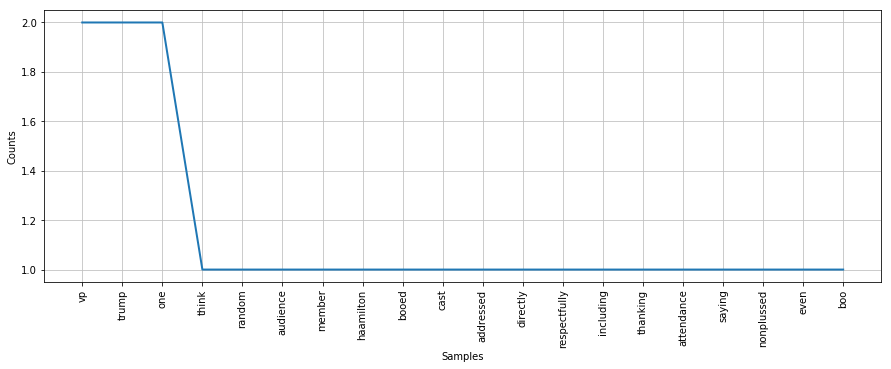

In [20]:
plt.figure(figsize=(15,5))
nltk.FreqDist(dict(sample.iloc[2]['wordcount'].most_common(20))).plot()


### Words positive or negative
Using flair only dataset

In [99]:
def get_word_count(df, sentiment):
    """ Get the word count according to the sentiment. Can be 'Positive', 'Negative', 'Neutral' or 'None' """
    if sentiment != 'None':
        filtered_df = df[df['label'] == sentiment]
    else:
        filtered_df = df.copy()
    fdists = list(filtered_df['wordcount'])
    tot_fd = nltk.FreqDist()
    for fdist in fdists:
        for key in fdist:
            tot_fd[key] += fdist.get(key)
            
    return tot_fd

sample_sorted_score = flair_politics.copy().sample(5000).sort_values(by=['score'], ascending=False)
sample_sorted_score['entity'] = sample_sorted_score['body'].apply(nlp_entity)
sample_sorted_score['sentiment'] = sample_sorted_score['body'].apply(nlp_sentiment)
sample_sorted_score['wordcount'] = sample_sorted_score['body'].apply(nlp_wordcount)
sample_sorted_score['label'] = sample_sorted_score['sentiment'].apply(sentiment_to_label)
sample_sorted_score.head()

,index,author,author_flair_text,body,created_utc,gilded,id,link_id,parent_id,score,entity,sentiment,wordcount,label
6474124,277048,3Suze,South Carolina,[Here is one of the ads he might sue over](htt...,2016-10-05 21:06:14,1,d8fk8jp,561k0t,d8fi07v,2180,PERSON Donnie,"0.7564,0.043,0.786,0.171","{'here': 1, 'one': 1, 'ad': 1, 'might': 1, 'su...",Positive
7208980,1011904,deathtotheemperor,Kansas,"You know, I just disagreed with Romney and McC...",2016-10-14 20:12:49,1,d8s83ze,57ibst,57ibst,1411,"PERSON Romney,GPE McCain,PERSON George W Bush,...","0.5514,0.129,0.69,0.181","{'you': 1, 'know': 1, 'disagreed': 1, 'romney'...",Positive
7840136,1643060,Byteflux,California,Seriously. Fuck this deal.,2016-10-24 00:29:45,0,d94y41w,591def,591def,1339,GPE Fuck,"-0.6369,0.722,0.278,0.0","{'seriously': 1, 'fuck': 1, 'deal': 1}",Negative
7203081,1006005,Lynx_Rufus,Maine,Gloria Allred is the jurisprudence version of ...,2016-10-14 18:50:00,0,d8s45kh,57hya5,57hya5,1315,"GPE Gloria,ORGANIZATION Allred,PERSON Omar Lit...","-0.6597,0.144,0.856,0.0","{'gloria': 1, 'allred': 1, 'jurisprudence': 1,...",Negative
7606136,1409060,WistfulAether,California,Congratulations to President Hillary Clinton,2016-10-20 02:37:28,0,d8zrs1d,58eh18,58eh18,1236,PERSON Hillary Clinton,"0.5994,0.0,0.506,0.494","{'congratulation': 1, 'president': 1, 'hillary...",Positive


#### Taking good scores into account

In [100]:
good_score = sample_sorted_score[sample_sorted_score['score'] > 50].copy()

In [101]:
word_positive_good = get_word_count(good_score, 'Positive')
word_negative_good = get_word_count(good_score, 'Negative')
word_count_good = get_word_count(good_score, 'None')

In [102]:
word_positive_good.most_common(10)

[('trump', 27),
 ('would', 20),
 ('like', 20),
 ('he', 14),
 ('republican', 13),
 ('one', 12),
 ('never', 12),
 ('if', 12),
 ('it', 11),
 ('election', 11)]

In [103]:
word_negative_good.most_common(10)

[('he', 19),
 ('people', 18),
 ('going', 15),
 ('trump', 14),
 ('fuck', 12),
 ('like', 10),
 ('the', 10),
 ('dont', 9),
 ('it', 8),
 ('right', 7)]

In [104]:
word_count_good.most_common(10)

[('trump', 53),
 ('he', 37),
 ('like', 36),
 ('people', 35),
 ('would', 31),
 ('going', 24),
 ('it', 23),
 ('the', 23),
 ('think', 22),
 ('dont', 21)]

#### Bad scores

In [105]:
bad_score = sample_sorted_score[sample_sorted_score['score'] < 0].copy()

bad_score.head()

,index,author,author_flair_text,body,created_utc,gilded,id,link_id,parent_id,score,entity,sentiment,wordcount,label
6549926,352850,Banned4SevenDays,Texas,Sounds like a German problem ehhhh?! This is A...,2016-10-07 14:10:13,0,d8hvdr6,56ak66,d8hus4z,-1,"GPE Sounds,GPE German,ORGANIZATION America Jack","-0.3382,0.131,0.768,0.102","{'sound': 1, 'like': 1, 'german': 1, 'problem'...",Negative
7835288,1638212,duffmanhb,Nevada,Eh liberal PACs definitely were involved. Peop...,2016-10-23 22:23:59,0,d94t5q5,58yror,58yror,-1,"ORGANIZATION PACs,ORGANIZATION PACs,PERSON Don...","-0.6249,0.113,0.855,0.031","{'eh': 1, 'liberal': 3, 'pac': 3, 'definitely'...",Negative
6527233,330157,winterd,Illinois,k,2016-10-06 22:04:09,0,d8h2le4,5669dj,d8h08u3,-1,,"0.0,0.0,0.0,0.0",{},Neutral
6993949,796873,1gnominious,Texas,There was even a stupid meme about it after a ...,2016-10-12 01:56:18,0,d8o7yz7,571iov,d8o7p0g,-1,"PERSON Hillary,PERSON Bernie","-0.2942,0.08,0.866,0.054","{'there': 1, 'even': 1, 'stupid': 1, 'meme': 1...",Negative
6521679,324603,SuperSulf,Florida,"Democrats don't stop people from voting, just ...",2016-10-06 20:07:54,0,d8gx010,565vp5,d8gw671,-1,"PERSON Sorry,GPE Americans,ORGANIZATION GOP","-0.0714,0.117,0.773,0.11","{'democrat': 1, 'dont': 2, 'stop': 1, 'people'...",Neutral


In [106]:
word_positive_bad = get_word_count(bad_score, 'Positive')
word_negative_bad = get_word_count(bad_score, 'Negative')
word_count_bad = get_word_count(bad_score, 'None')

In [107]:
word_positive_bad.most_common(10)

[('like', 15),
 ('trump', 15),
 ('clinton', 14),
 ('get', 9),
 ('im', 9),
 ('you', 9),
 ('he', 9),
 ('well', 9),
 ('right', 8),
 ('know', 8)]

In [108]:
word_negative_bad.most_common(10)

[('people', 22),
 ('hillary', 21),
 ('trump', 17),
 ('dont', 15),
 ('like', 13),
 ('he', 13),
 ('election', 13),
 ('would', 12),
 ('im', 12),
 ('gt', 12)]

In [109]:
word_count_bad.most_common(10)

[('trump', 43),
 ('like', 36),
 ('people', 34),
 ('hillary', 30),
 ('it', 27),
 ('clinton', 26),
 ('dont', 25),
 ('im', 24),
 ('he', 23),
 ('get', 22)]

#### Compare good and bad
Which one are in both sets?

In [110]:
both = []
good_only = nltk.FreqDist()
for good in word_count_good:
    if good in word_count_bad:
        both.append(good)
    else:
        good_only[good] = word_count_good.get(good)

In [111]:
both[:10]

['one',
 'ad',
 'might',
 'probably',
 'would',
 'another',
 'edit',
 'looking',
 'it',
 'mean']

In [112]:
good_only.most_common(10)

[('romney', 6),
 ('paid', 6),
 ('whole', 6),
 ('week', 5),
 ('address', 5),
 ('obamacare', 5),
 ('medicare', 5),
 ('expectation', 4),
 ('hour', 4),
 ('elected', 4)]

In [113]:
bad_only = nltk.FreqDist()
for bad in word_count_bad:
    if bad not in word_count_good:
        bad_only[bad] = word_count_bad.get(bad)

In [114]:
bad_only.most_common(10)

[('percent', 8),
 ('sander', 7),
 ('primary', 6),
 ('common', 6),
 ('criminal', 6),
 ('10', 6),
 ('crime', 5),
 ('russia', 5),
 ('general', 5),
 ('crash', 5)]

## Entities

In [162]:
flair_politics['entity'] = flair_politics['body'].apply(nlp_entity)
flair_politics['sentiment'] = flair_politics['body'].apply(nlp_sentiment)
flair_politics['wordcount'] = flair_politics['body'].apply(nlp_wordcount)
flair_politics['label'] = flair_politics['sentiment'].apply(sentiment_to_label)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

In [163]:
flair_politics.head()

,index,author,author_flair_text,body,created_utc,gilded,id,link_id,parent_id,score,entity,sentiment,wordcount,label
6147305,1669459,Qu1nlan,California,Hi `juno255`. Thank you for participating in /...,2016-09-30 02:31:46,0,d87sxgv,5552n9,5552n9,1,"PERSON Title,ORGANIZATION Reddit","0.8738,0.0,0.883,0.117","{'hi': 1, 'juno255': 1, 'thank': 1, 'participa...",Positive
6147372,1669526,Qu1nlan,California,Hi `Alejandro_Last_Name`. Thank you for partic...,2016-09-30 02:33:36,0,d87t05c,5556yb,5556yb,1,"PERSON Title,ORGANIZATION Reddit","0.8738,0.0,0.883,0.117","{'hi': 1, 'alejandrolastname': 1, 'thank': 1, ...",Positive
6147390,1669544,Qu1nlan,California,Hi `ImNotJesus`. Thank you for participating i...,2016-09-30 02:33:57,0,d87t0p2,5548v7,5548v7,1,"ORGANIZATION ImNotJesus,PERSON Title,ORGANIZAT...","0.8738,0.0,0.883,0.117","{'hi': 1, 'imnotjesus': 1, 'thank': 1, 'partic...",Positive
6147458,1669612,Qu1nlan,California,Hi `cmonshoe`. Thank you for participating in ...,2016-09-30 02:35:17,0,d87t2mq,5541x2,5541x2,1,"PERSON Rehosted Content,GPE Video,ORGANIZATION...","0.9163,0.0,0.843,0.157","{'hi': 1, 'cmonshoe': 1, 'thank': 1, 'particip...",Positive
6147507,1669661,Qu1nlan,California,Hi `abourne`. Thank you for participating in /...,2016-09-30 02:36:23,0,d87t4ep,554okj,554okj,1,"PERSON Title,ORGANIZATION Reddit","0.8738,0.0,0.883,0.117","{'hi': 1, 'abourne': 1, 'thank': 1, 'participa...",Positive


In [169]:
#remplacé ancienne methode score par celle ci pour pas faire 2 loops
def get_score(row, candidate1, candidate2, out_states, score= False):
    current_state = row['author_flair_text']
    firstName1=candidate1[0]
    lastName1=candidate1[1]
    firstName2=candidate2[0]
    lastName2=candidate2[1]
    if firstName1 in row['entity'] or lastName1 in row['entity']:
        if row['label'] == 'Positive': 
            if score : 
                out_states.loc[current_state, 'score_'+lastName1] += row['score']
            else :
                out_states.loc[current_state, 'score_'+lastName1] += 1
        elif row['label'] == 'Negative':
            if score : 
                out_states.loc[current_state, 'score_'+lastName1] -= row['score']
            else :
                out_states.loc[current_state, 'score_'+lastName1] -= 1
    
    if firstName2 in row['entity'] or lastName2 in row['entity']:
        if row['label'] == 'Positive':          
            if score : 
                out_states.loc[current_state, 'score_'+lastName2] += row['score']
            else :
                out_states.loc[current_state, 'score_'+lastName2] += 1
        elif row['label'] == 'Negative':
            if score : 
                out_states.loc[current_state, 'score_'+lastName2] -= row['score']
            else :
                out_states.loc[current_state, 'score_'+lastName2] -= 1

In [170]:
def comp_winner(state_df):
    final_score = []
    for state in state_df.index :
        if (state_df.loc[state, 'score_Clinton']>state_df.loc[state, 'score_Trump']):
            #0 if Clinton wins
            final_score.append(0)
        else :
            #1 if Trump wins
            final_score.append(1)
    return final_score

## Scores do not count : 

In [171]:
state_df = states.copy()
state_df.set_index('State', inplace=True)
state_df.head()

,Abbreviation
State,
Alabama,AL
Alaska,AK
Arizona,AZ
Arkansas,AR
California,CA


In [172]:
state_df['score_Trump'] = 0
state_df['score_Clinton'] = 0
candidate1 = ['Donald', 'Trump']
candidate2 = ['Hillary', 'Clinton']

flair_politics.apply(get_score, candidate1=candidate1, candidate2=candidate2, out_states=state_df, axis=1)
state_df['Winner'] = comp_winner(state_df)
state_df.reset_index(inplace = True)
state_df.set_index('Abbreviation', inplace=True)

state_df.head()

,State,score_Trump,score_Clinton,Winner
Abbreviation,,,,
AL,Alabama,9,16,0
AK,Alaska,-26,2,0
AZ,Arizona,-16,-25,1
AR,Arkansas,7,1,1
CA,California,102,189,0


In [143]:
def us_election_colors(state_df, state):
    """Maps Clinton wins to blue and Trump wins to red."""
    clinton_win = state_df.loc[state, 'Winner'] == 0
    if clinton_win:
        return '#0000ff'
    else:
        return '#ff0000'

In [167]:
state_geo_path = DATA_PATH + r'us-states.json'
geo_json_data = json.load(open(state_geo_path))

results_map = folium.Map([43,-100], tiles='cartodbpositron', zoom_start=4)
folium.GeoJson(
    geo_json_data,
    style_function=lambda feature: {
        'fillColor': us_election_colors(state_df, feature['id']),
        'color' : 'black',
        'weight' : 2,
        'dashArray' : '5, 5'
        }
    ).add_to(results_map)

results_map

In [168]:
results_map.save('US_Election_Prediction_2016.html')

## Scores count :

In [176]:
state_df2 = states.copy()
state_df2.set_index('State', inplace=True)
state_df2['score_Trump'] = 0
state_df2['score_Clinton'] = 0

flair_politics.apply(get_score, candidate1=candidate1, candidate2=candidate2, out_states=state_df2, score=True, axis=1)
state_df2['Winner'] = comp_winner(state_df2)
state_df2.reset_index(inplace = True)
state_df2.set_index('Abbreviation', inplace=True)

state_df2.head()

,State,score_Trump,score_Clinton,Winner
Abbreviation,,,,
AL,Alabama,-557,591,0
AK,Alaska,747,523,1
AZ,Arizona,-151,230,0
AR,Arkansas,-980,-37,0
CA,California,4939,4770,1


In [177]:
results_map_score = folium.Map([43,-100], tiles='cartodbpositron', zoom_start=4)
folium.GeoJson(
    geo_json_data,
    style_function=lambda feature: {
        'fillColor': us_election_colors(state_df2, feature['id']),
        'color' : 'black',
        'weight' : 2,
        'dashArray' : '5, 5'
        }
    ).add_to(results_map_score)

results_map_score

In [178]:
results_map_score.save('US_Election_Pred_Using_Scores_2016.html')

## Visualizing data

To get a feel for the dataset, a histogram with the number of comments for each day is plotted.

In [37]:
# computation of the number of days the dataset spans
days = (politics.iloc[-1].created_utc - politics.iloc[0].created_utc).days + 1

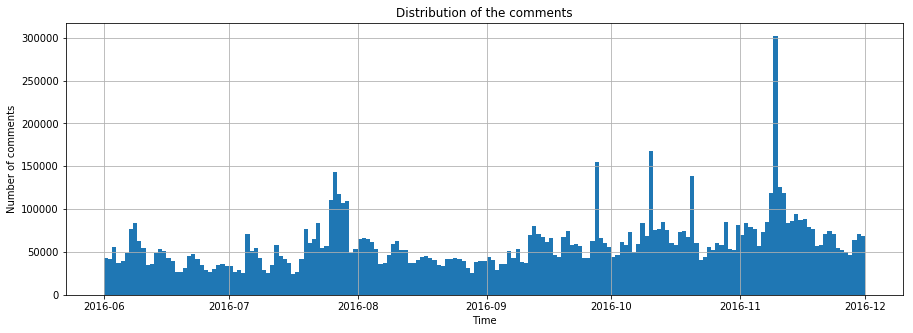

In [38]:
plt.figure(figsize=(15,5))
plt.grid()
plt.hist(politics['created_utc'], bins=days)
plt.ylabel('Number of comments')
plt.xlabel('Time')
plt.title('Distribution of the comments')
plt.show()